# Compare Modeled and Measured Temperatures, Densities, and heights+densities to field observations

In [8]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from tqdm import tqdm

from funcs.clean import clean

In [9]:
import os
fig_dir = '../../figures/'

In [10]:
meas = clean('../../data/snowschool/wx_data/winter_20_21.csv')

/home/zacharykeskinen/Documents/temp/src/analysis/funcs/clean.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wx[col] = wx[col].apply(pd.to_numeric, errors = 'ignore')


In [13]:
import json
import numpy as np
import pandas as pd
import plotly.express as px

fp = '../../modeling/output/v20220206/jsons/SnowSchool 1.timeline.json'
# Opening JSON file
f = open(fp,)
# returns JSON object as
# a dictionary
data = json.load(f)
# Closing file
f.close()

model = pd.DataFrame()
for profile in data['profiles']:
    model = model.append(profile, ignore_index= True)

In [15]:
field_fp = '../../data/snowschool/field_data/SWE Observations 2015_2021.xlsx'
xls = pd.ExcelFile(field_fp)

In [16]:
t = pd.read_excel(xls, None).keys()

In [17]:
field_df = pd.DataFrame(columns = ['depth', 'swe'])
for n in t:
    if n[-2:] == '20' or n[-2:] == '21':
        if len(n) == 5:
            d = pd.to_datetime(f'{n[:1]}-{n[1:3]}-{n[-2:]}')
            sd = pd.read_excel(xls, n)['Snow depth (in)'][2:14]
            swe = pd.read_excel(xls, n)['Net SWE (In)'][2:14]
        if len(n) == 6:
            d = pd.to_datetime(f'{n[:2]}-{n[2:4]}-{n[-2:]}')
            sd = pd.read_excel(xls, n)['Snow depth (in)'][2:14]
            swe = pd.read_excel(xls, n)['Net SWE (In)'][2:14]
        if len(n) == 8:
            d = pd.to_datetime(f'{n[:2]}-{n[2:4]}-{n[-4:]}')
            sd = pd.read_excel(xls, n)['Snow depth (in)'][2:14]
            swe = pd.read_excel(xls, n)['Net SWE (In)'][2:14]
        field_df.loc[d, 'depth'] = sd.values
        field_df.loc[d, 'swe'] = swe.values
for i, r in field_df.iterrows():
    field_df.loc[i, 'depth'] = [j*2.54/100 for j in r.depth]
    field_df.loc[i, 'swe'] = [j*2.54/100 for j in r.swe]

# Depths

In [18]:
model_depths = pd.DataFrame(index = meas.index, columns = ['hs'])
for i, r in model.iterrows():
    model_depths.loc[pd.to_datetime(r.date), 'hs']= r.comments['elements'][0]['layers'][-1]['top']/100
model_depths.hs = model_depths.hs.astype('f8')

In [19]:
print(f'Measured peak snowdepth: {meas.snow_depth_1.idxmax()}')
print(f'Modeled peak snowdepth: {model_depths.hs.idxmax()}')

Measured peak snowdepth: 2021-02-21 03:00:00+00:00
Modeled peak snowdepth: 2021-02-21 11:00:00+00:00


In [20]:
field_df = field_df[field_df.index > '2020-10-01']

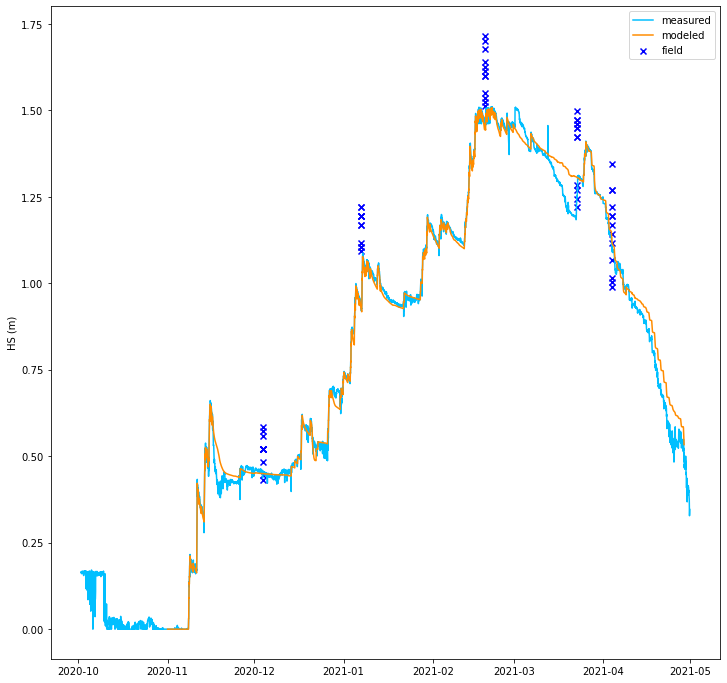

In [21]:
plt.figure(figsize = (12,12))
plt.plot(meas.snow_depth_1, label = 'measured', color = 'deepskyblue')
plt.plot(model_depths, label = 'modeled', color = 'darkorange')

for i, r in field_df.iterrows():
    for j in r.depth:
        plt.scatter(i, j, color = 'blue', marker = 'x')
plt.scatter(i, j, color = 'blue', marker = 'x',label = 'field')
plt.legend()
plt.ylabel('HS (m)')
plt.savefig(os.path.join(fig_dir, 'hs_compare_field.png'))
plt.show()

## Density Compare

In [22]:
heights = np.linspace(0,1.4,29)
extracted_densities = pd.DataFrame(columns = heights, index = meas.index)
for i, r in tqdm(model.iterrows()):
    if type(r.density) is not float:
        for layer in r.density['elements'][0]['layers']:
            layer_heights = heights[(heights <= layer['top']/100) & (heights >= layer['bottom']/100)]
            if layer_heights.size > 0:
                for h in layer_heights:
                    extracted_densities.loc[pd.to_datetime(r.date), h] = layer['value']
den_arr = extracted_densities.values.astype('f8')
den_arr = np.rot90(den_arr)

4297it [00:23, 180.28it/s]


In [23]:
extracted_ave_densities = pd.DataFrame(columns = ['density'], index = meas.index)
for i, r in tqdm(model.iterrows()):
    if type(r.density) is not float:
        dens_aver = 0
        for layer in r.density['elements'][0]['layers']:
            depth = layer['top'] - layer['bottom']
            dens_aver += depth*layer['value']/r.density['elements'][0]['layers'][-1]['top']
        extracted_ave_densities.loc[pd.to_datetime(r.date), 'density'] = dens_aver

4297it [00:03, 1175.84it/s]


In [24]:
meas.precip_accum_1

date_time
2020-10-02 00:00:00+00:00    0.429514
2020-10-02 01:00:00+00:00    0.429514
2020-10-02 02:00:00+00:00    0.429260
2020-10-02 03:00:00+00:00    0.429006
2020-10-02 04:00:00+00:00    0.429006
                               ...   
2021-04-30 19:00:00+00:00    0.113538
2021-04-30 20:00:00+00:00    0.113792
2021-04-30 21:00:00+00:00    0.113792
2021-04-30 22:00:00+00:00    0.113792
2021-04-30 23:00:00+00:00    0.113792
Name: precip_accum_1, Length: 5079, dtype: float64

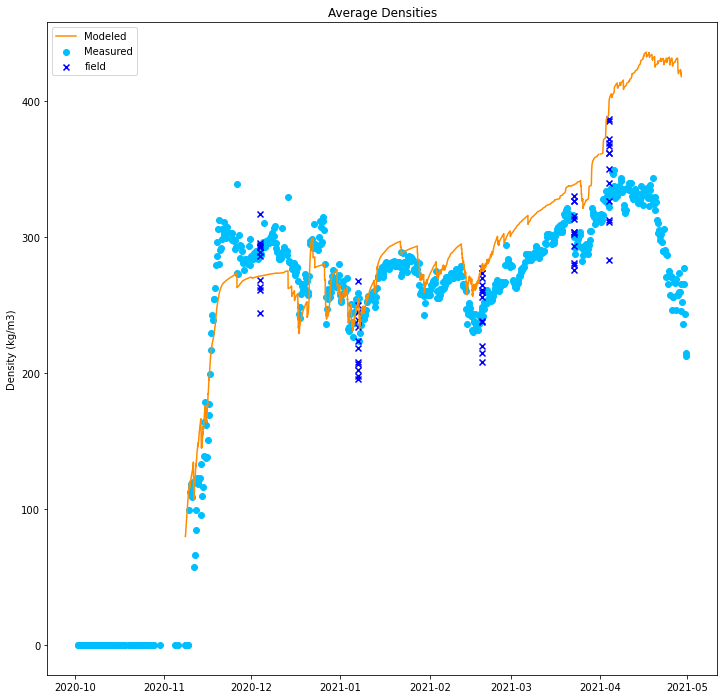

In [25]:
f = plt.figure(figsize = (12,12))
plt.plot(extracted_ave_densities, label = 'Modeled', color = 'darkorange')
meas.loc[:, 'ave_density'] = meas.snow_water_equiv_1 / meas.snow_depth_1
plt.scatter(x = meas.index, y = meas.ave_density, label = 'Measured', color = 'deepskyblue')

for i, r in field_df.iterrows():
    densities = [a_i / b_i*1000 for a_i, b_i in zip(r.swe, r.depth)]
    for j in densities:
        plt.scatter(i, j, color = 'blue', marker = 'x')
plt.scatter(i, j, color = 'blue', marker = 'x', label = 'field')
plt.legend()
plt.title('Average Densities')
plt.ylabel('Density (kg/m3)')
plt.savefig(os.path.join(fig_dir, 'mod_meas_field_dens.png'))

## SWE

In [26]:
model_swes = pd.DataFrame(model_depths[:-1].values *  extracted_ave_densities.values, index = meas.index)

In [27]:
meas.precip_accum_1[meas.index > '2020-11-04']

date_time
2020-11-04 01:00:00+00:00    0.109728
2020-11-04 02:00:00+00:00    0.109474
2020-11-04 03:00:00+00:00    0.109474
2020-11-04 04:00:00+00:00    0.109220
2020-11-04 05:00:00+00:00    0.109220
                               ...   
2021-04-30 19:00:00+00:00    0.113538
2021-04-30 20:00:00+00:00    0.113792
2021-04-30 21:00:00+00:00    0.113792
2021-04-30 22:00:00+00:00    0.113792
2021-04-30 23:00:00+00:00    0.113792
Name: precip_accum_1, Length: 4287, dtype: float64

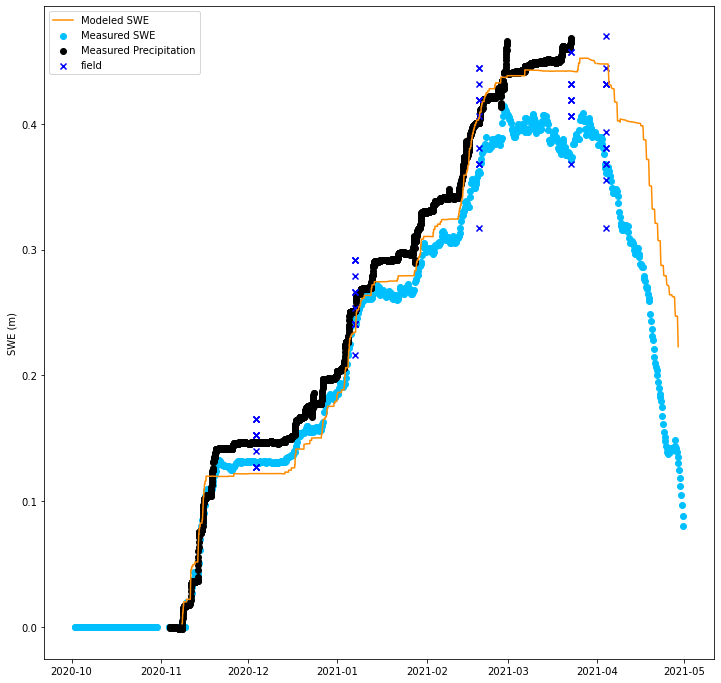

In [28]:
plt.figure(figsize = (12,12))
plt.scatter(x = meas.index, y = meas.snow_water_equiv_1/1000, label = 'Measured SWE', color = 'deepskyblue')
plt.plot(model_swes/1000, label = 'Modeled SWE', color = 'darkorange')
plt.scatter(x = meas.index[(meas.index>'2020-11-04') & (meas.index < '2021-03-23')], y = meas.precip_accum_1[(meas.index>'2020-11-04') & (meas.index < '2021-03-23')] - 0.109728, label = 'Measured Precipitation', color = 'black', alpha = 1)

for i, r in field_df[field_df.index > '2020-10-01'].iterrows():
    for j in r.swe:
        plt.scatter(i, j, color = 'blue', marker = 'x')
plt.scatter(i, j, color = 'blue', marker = 'x', label = 'field')

plt.legend()
plt.ylabel('SWE (m)')
plt.savefig(os.path.join(fig_dir, 'swe_compare_field.png'))